In [8]:
# Activate the library
import Pkg
Pkg.activate("../")

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


In [10]:
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Statistics", "Random", "QuadGK", "Plots", "LaTeXStrings", "OrdinaryDiffEq"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

Precompiling QuTaM
  ✓ QuTaM
  1 dependency successfully precompiled in 4 seconds. 249 already precompiled.


In [11]:
println(Threads.nthreads())

4


# Exploration: Looking for the relaxation time
I will be using a model of radiative damping since it's easy to obtains it's FI. Particularly, I found that:

$$ F(\gamma) = \frac{1-e^{-\gamma T}}{\gamma^2}. $$

The first thing I want to know is how long I should look, for that I test the relaxation time.

In [15]:
EPS = 0e-5 # Tolerance for the distance respect to the Frobenious norm
delta= 0 # Detuning
omega = 1.0 # Rabi Frequency
gamma = 0.5
# Define the Analytical Solution

function rf_de!(dr, r, p, t)
    dr[1] = -0.5*gamma*r[1] - delta*r[2]
    dr[2] = delta*r[1] - 0.5*gamma*r[2] - omega*r[3]
    dr[3] = omega*r[2] - gamma*(r[3] + 1)
end
H = -delta*QuTaM.sigma_p*QuTaM.sigma_m + 0.5*omega*QuTaM.sigma_x

psi0 = zeros(ComplexF64, 2)
psi0[1] = 1 # Initial condition

sys = System(H, # Hamiltonian
[sqrt(gamma)*QuTaM.sigma_m]) #Jump Operators
params = SimulParameters(psi0,
    40.0, # Final time. Set very long so that all trajectories jump
    1, # seed
    10_000, # Number of trajectories
    10_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)

SimulParameters(psi0=ComplexF64[1.0 + 0.0im, 0.0 + 0.0im]
nsamples=10000
seed=1
ntraj=10000)
multiplier=4.0
tf=40.0
dt=0.016
eps=0.001)

In [5]:
r0 = [0.0; 0.0; -1.0] # Initial Condition
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000));

LoadError: UndefVarError: `params` not defined

In [6]:
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

LoadError: UndefVarError: `ODEProblem` not defined

In [22]:
################## Average Simulation ################3
# Now from each trajectory, generate the states the given times
@time begin 
sample_clicks = QuTaM.run_trajectories(sys, params; progbar=false)
end 
ntimes = size(t_given)[1]
sample = zeros(ComplexF64, ntimes, sys.NLEVELS, params.ntraj)
for n in 1:params.ntraj
    states = QuTaM.evaluate_at_t(t_given, sample_clicks[n], sys,  params.psi0)
    for j in 1:sys.NLEVELS
        for tn in 1:ntimes
            sample[tn, j, n] = states[tn, j]
        end 
    end 
end

 76.802256 seconds (973.29 M allocations: 87.788 GiB, 22.90% gc time, 0.36% compilation time)


10000-element Vector{Vector{DetectionClick}}:
 [DetectionClick(0.3840384038403843, 1), DetectionClick(4.5924592459245925, 1), DetectionClick(2.2082208220822084, 1), DetectionClick(4.016401640164016, 1), DetectionClick(4.880488048804881, 1), DetectionClick(29.442944294429445, 1)]
 [DetectionClick(2.6082608260826086, 1), DetectionClick(42.94829482948295, 1)]
 [DetectionClick(8.800880088008801, 1), DetectionClick(4.144414441444145, 1), DetectionClick(2.8962896289628963, 1), DetectionClick(2.08020802080208, 1), DetectionClick(3.44034403440344, 1), DetectionClick(2.6882688268826884, 1), DetectionClick(1.6641664166416643, 1), DetectionClick(0.9120912091209123, 1), DetectionClick(5.152515251525153, 1), DetectionClick(2.112211221122112, 1), DetectionClick(1.6481648164816483, 1), DetectionClick(4.704470447044705, 1)]
 [DetectionClick(15.93759375937594, 1), DetectionClick(0.6720672067206723, 1), DetectionClick(2.6722672267226724, 1), DetectionClick(7.488748874887489, 1), DetectionClick(2.7842784

In [41]:
# Obtain the observable on the sample.
r_sample = zeros(Float64, ntimes, 3, params.ntraj)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]

@time begin
for j in 1:params.ntraj
    for k in 1:3
        for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[tn, :, j], sigma[k] * sample[tn, :, j])   # Drop the extra dimension
        end
    end
end 
end
# Average
r_avg = dropdims(mean(r_sample, dims=3), dims=3);

 33.664906 seconds (411.95 M allocations: 14.633 GiB, 4.13% gc time)


In [42]:
tau_sample = Vector{Float64}()
@time begin
for traj in sample_clicks
    if !isempty(traj)
        #    push!(tau_sample, traj[1].time)
        for click in traj
            push!(tau_sample, click.time)
        end 
    else
        continue
    end 
end 
end

  0.019289 seconds (407.98 k allocations: 12.651 MiB)


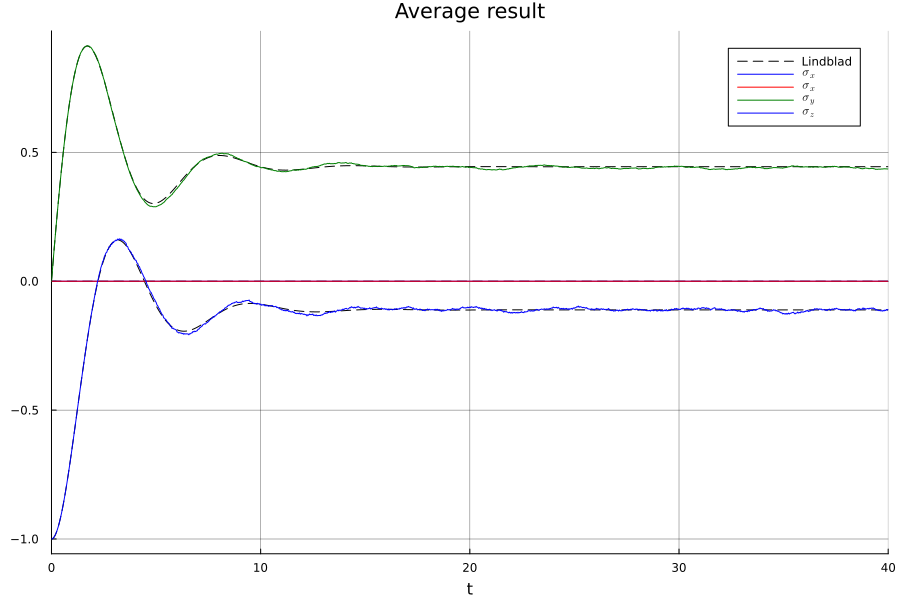

In [43]:
index_range = 1:size(t_given)[1]

plot(sol[index_range], idxs =(0, 1), seriescolor="black", label="Lindblad",  line=:dash)
plot!(t_given[index_range], r_avg[index_range, 1],  label=L"\sigma_x" , seriescolor=:blue)
#
plot!(sol[index_range], idxs =(0, 2), seriescolor="black", label=:false,  line=:dash)
plot!(sol[index_range], idxs =(0, 3), seriescolor="black", label=:false,  line=:dash)

plot!(t_given[index_range], r_avg[index_range, 1],  label=L"\sigma_x" , seriescolor=:red)
plot!(t_given[index_range], r_avg[index_range, 2],  label=L"\sigma_y" , seriescolor=:green)
plot!(t_given[index_range], r_avg[index_range, 3],  label=L"\sigma_z" , seriescolor=:blue)


plot!(title="Average result", xlabel="t", grid=:true, gridalpha=0.6, size=(900,600))

# Calculating the Monitoring Operator
The key to access the FI is to use the monitoring operator:

$$ |\xi_N(t_n,...,t_1)\rangle = \frac{\partial_\theta|\psi(t_n, ...,t_1) \rangle}{\langle\psi(t_n, ...,t_1)|\psi(t_n, ...,t_1) \rangle}$$

so the first thing in order is to obtain this thing, conditioned on a trajectory.

In [44]:
dHe = [[0.0 + 0im, 0] [0, 1]]
dLs = [zeros(ComplexF64, sys.NLEVELS, sys.NLEVELS)]

1-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

In [45]:
sample_xi = zeros(ComplexF64, ntimes, sys.NLEVELS, sys.NLEVELS, params.ntraj)
for k in 1:params.ntraj
    sample_xi[:, :, :, k] = MonitoringInBetween(sample_clicks[k], sys, dHe, dLs, params, t_given);
end 

In [46]:
fi_sample = Array{Float64}(undef, ntimes, params.ntraj)
for k in 1:params.ntraj
    for tn in 1:ntimes
        fi_sample[tn, k] = real(tr(sample_xi[tn, :, :, k]))^2
    end 
end 

In [47]:
FI = dropdims(mean(fi_sample, dims=2), dims=2);

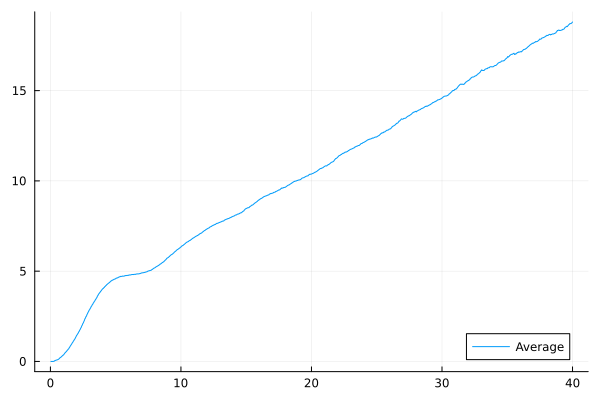

In [49]:
plot(t_given, FI./t_given, label="Average")